## Performing Exploratory Data Analysis for Student Retention

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as stats

from tools.utils import combine_columns, compute_feature_importance

In [2]:
# Load in cleaned data
data = pd.read_csv("data/Most-Recent-Cohorts-Institution-filtered.csv")
data = data.drop('Unnamed: 0', axis=1)

In [3]:
four_yr_retention = data.RET_FT4
less_four_yr_retention = data.RET_FTL4

# Does number of programs offered (PRGMOFR) affect retention?

Notice that of the institutions with data, a large proportion offer only a few programs. Upon close inspection, these appear to be highly specialized trade schools

In [4]:
data.PRGMOFR.value_counts()[:10]

1.0     379
2.0     352
3.0     342
4.0     309
5.0     214
6.0     156
7.0     105
9.0      72
8.0      60
10.0     43
Name: PRGMOFR, dtype: int64

Take "New Beginning College of **Cosmetology**" or "Elite **Welding** Academy South Point", for example

In [5]:
data[data.PRGMOFR<=10].INSTNM

17         New Beginning College of Cosmetology
60           Alaska Vocational Technical Center
62                        Alaska Career College
63                  Empire Beauty School-Tucson
64             Carrington College-Phoenix North
                         ...                   
6116     San Joaquin Valley College-Porterville
6118                  Ruben's Five Star Academy
6123         Miller-Motte College-Chattanooga 2
6125          Elite Welding Academy South Point
6126    Zorganics Institute Beauty and Wellness
Name: INSTNM, Length: 2032, dtype: object

Note that ```UNITID``` is the pkey, and that 98 Institutions of the same name are connected to multiple ```UNITID```'s

In [7]:
print("UNITID is the primary key: ", len(data) == len(data.groupby("UNITID")))
print("INSTNM is the primary key: ", len(data) == len(data.groupby("INSTNM")))

UNITID is the primary key:  True
INSTNM is the primary key:  False


We hypothesize that institutions with thh same name ```INSTNM``` are actually the same parent institution with sub-institutions denoted by different ```UNITID```'s.

This would mean that the number of programs offered is undercounted, and we should sum the number of programs offered for each 'parent institution'.

Let us informally explore this hypothesis.

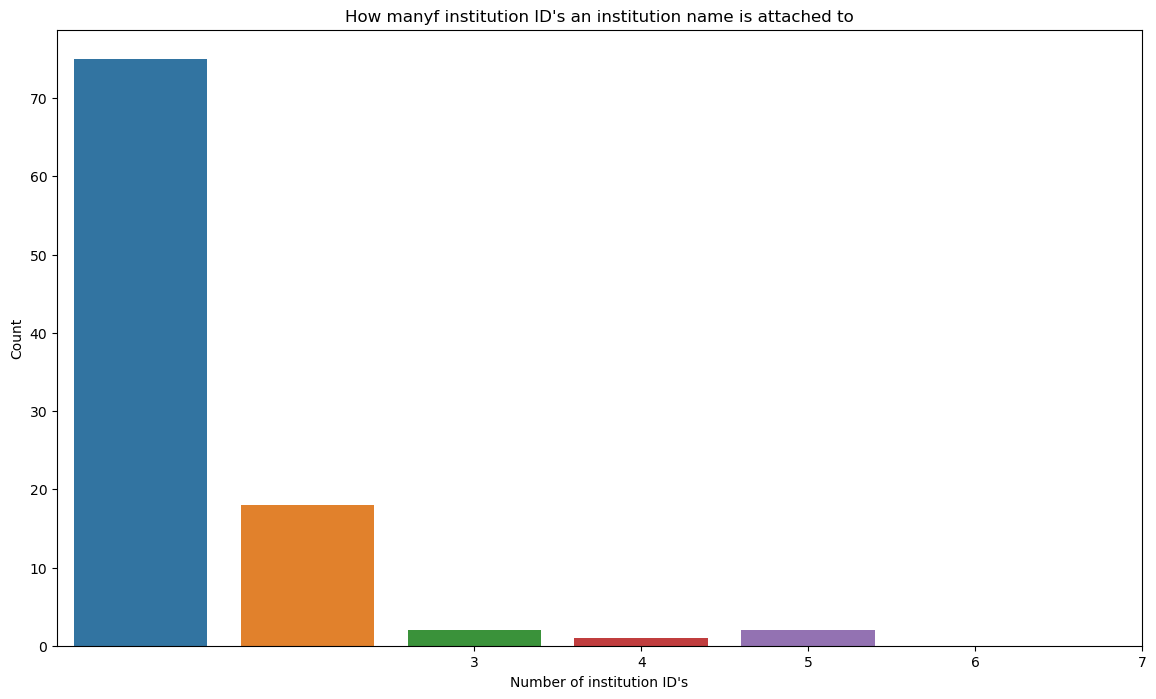

In [9]:
#find the number of schools by the same name
duplicates_by_instnm = data.groupby("INSTNM").UNITID.count().sort_values(ascending=False)
duplicates = duplicates_by_instnm[duplicates_by_instnm>1]
counts = duplicates.value_counts().sort_index()

# bar plot of how many institution ID's a name is attached to
ax = plt.subplot()
sns.barplot(x=counts.index, y=counts)
ax.set_title("How manyf institution ID's an institution name is attached to")
ax.set_ylabel("Count")
ax.set_xlabel("Number of institution ID's")
ax.set_xticks(np.arange(2, 7, dtype=int))
ax.set_xticklabels(duplicates.value_counts().sort_index().index.values+1)
ax.grid(False);


Most institutions are only connected to one institution ID and name, but there are enough names connected to multiple institutions that they could represent a different relationship with student retention. 

Let's explore ```PRGMOFR```'s institutions with 'duplicate' rows (one for each sub-institution) separately from ```PRFMOFR``` as a whole.

In [10]:
#aggregate information on institution by each name
inst_per_instnm = data.groupby("INSTNM")[["UNITID", "PRGMOFR", "CITY"]]\
    .agg([list, len]).sort_values([("CITY", "len")], ascending=False)\
    .drop(columns=[(col, "len") for col in ["UNITID", "PRGMOFR"]])
inst_per_instnm.head()

UNITID  \
                                                                      list   
INSTNM                                                                       
Jersey College           [455196, 45519601, 45519602, 45519603, 4551960...   
Cortiva Institute         [128896, 134574, 215044, 387925, 434308, 438285]   
Columbia College                  [112561, 177065, 217934, 455983, 479248]   
Arthur's Beauty College                   [106360, 106494, 445540, 489830]   
Unitek College                          [459204, 476799, 479424, 45920401]   

                                                PRGMOFR  \
                                                   list   
INSTNM                                                    
Jersey College           [9.0, nan, nan, nan, nan, nan]   
Cortiva Institute        [1.0, 3.0, 1.0, 4.0, 2.0, 4.0]   
Columbia College              [nan, nan, nan, 8.0, 4.0]   
Arthur's Beauty College            [2.0, 2.0, 2.0, 2.0]   
Unitek College                     [nan, 2.0, 2.0, nan]   

                                                                      CITY      
                                                                      list len  
INSTNM                                                                          
Jersey College           [Teterboro, Tampa, Ewing, Jacksonville, Sunris...   6  
Cortiva Institute        [Cromwell, St. Petersburg, King of Prussia, Po...   6  
Columbia College         [Sonora, Columbia, Columbia, Vienna, Centreville]   5  
Arthur's Beauty College      [Fort Smith, Jacksonville, Conway, Jonesboro]   4  
Unitek College            [Fremont, South San Francisco, Hayward, Fremont]   4

As a sanity check, let's look at Unitek college. From a google search, it is in fact the same Univrsity with multiple campuses. 

We cannot manually verify this for all of the institutions in the dataset, so let us first see if this analysis is worth pursuing by examining the correlation with student retention rate.

In [11]:
#sum the PRGMOFR values for each institution name, treating np.nan's as 0
PRGMOFR_with_dups = inst_per_instnm[[("PRGMOFR", "list")]].apply(lambda x: np.nansum(x.values[0]), axis=1)
PRGMOFR_dups_sample = data[data.INSTNM.isin(PRGMOFR_with_dups.index.values)]

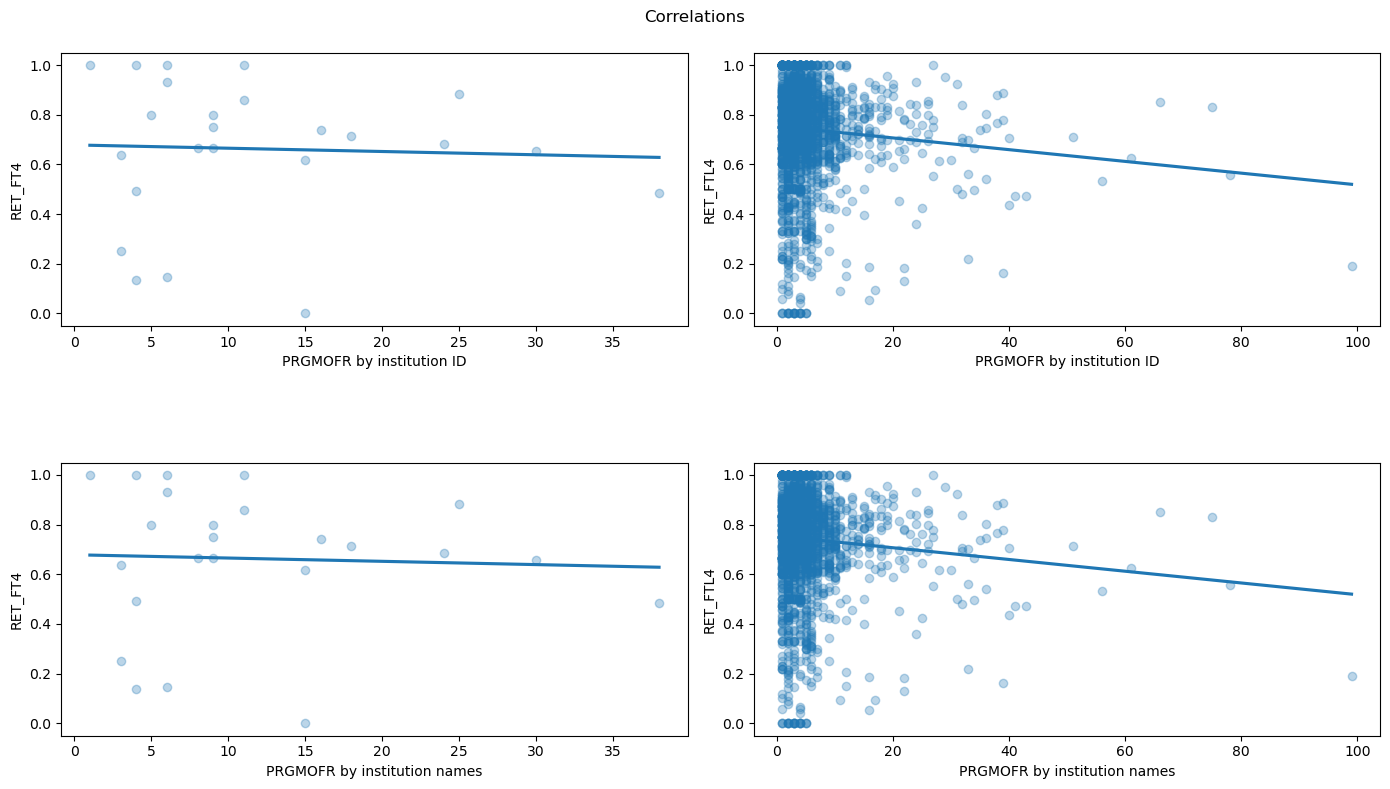

In [13]:
fig, axs = plt.subplots(2, 2)
sns.regplot(x = "PRGMOFR", y = "RET_FT4", data = PRGMOFR_dups_sample, scatter_kws={'alpha':0.3}, ci=False, ax=axs[0,0])
axs[0,0].set_xlabel("PRGMOFR by institution ID")
pos = axs[0,0].get_position()
pos.y0 += .4
axs[0,0].set_position(pos)
sns.regplot(x = "PRGMOFR", y = "RET_FTL4", data = PRGMOFR_dups_sample, scatter_kws={'alpha':0.3}, ci=False, ax=axs[0,1])
axs[0,1].set_xlabel("PRGMOFR by institution ID")
pos = axs[0,1].get_position()
pos.y0 += .4
axs[0,1].set_position(pos)
sns.regplot(x = "PRGMOFR", y = "RET_FT4", data = data, scatter_kws={'alpha':0.3}, ci=False, ax=axs[1,0])
axs[1,0].set_xlabel("PRGMOFR by institution names")
sns.regplot(x = "PRGMOFR", y = "RET_FTL4", data = data, scatter_kws={'alpha':0.3}, ci=False, ax=axs[1,1])
axs[1,1].set_xlabel("PRGMOFR by institution names")
fig.tight_layout()
fig.subplots_adjust(hspace=.5)
fig.suptitle("Correlations");

Looking at the scatterplots, the relationships are roughly linear, and the correlations between retention rate at 4-years ```RET_FT4```, at less-than-4-years ```RET_FTL4```, and the number of programs by institution and by the name of potentially parent institutions are extermely weak therefore we will not pursue this variable further.

It shuold be noted that if there are parent institutions with many sub-institutions' ID's ```UNITID```, that parent institution may not have all its sub-institutions labeled with the same name ```INSTNM```. Furthremore, institutions could have the same name by conincedence and not be related. If further information on parent-institutinos becomes available, we can pursue this idea again. 

Furthermore, a large proportion of ```PRGMOFR``` is null, meaning that our analysis on the non-nulls may not be representative of the sample and therefore of the population.

Therefore, ```PRGMOFR``` cannot be proven to be significantly associated with student retention features ```RET_FT4``` and ```RET_FTL4```